In [1]:
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import multiprocessing
import os
import time
import gloce as gc
from osgeo import gdal
from osgeo import gdalconst
from mpl_toolkits.basemap import Basemap
from glob import glob
from math import ceil
import seaborn as sns
from scipy import stats
from scipy.stats import gaussian_kde
#return im_data, im_width, im_height, im_geotrans, im_proj
def read_img(filename):
    dt = gdal.Open(filename)
    im_width = dt.RasterXSize
    im_height = dt.RasterYSize
    im_bands = dt.RasterCount
    im_geotrans = dt.GetGeoTransform()
    im_proj = dt.GetProjection()
    im_data = dt.ReadAsArray(0,0,im_width,im_height)
    return im_data, im_width, im_height, im_geotrans, im_proj
def write_img(filename, im_proj, im_geotrans, im_data):
    if 'int8' in im_data.dtype.name:
        datatype = gdal.GDT_Byte
    elif 'int16' in im_data.dtype.name:
        datatype = gdal.GDT_UInt16
    else:
        datatype = gdal.GDT_Float32
    if len(im_data.shape) == 3:
        im_bands, im_height, im_width = im_data.shape
    else:
        im_bands, (im_height, im_width) = 1, im_data.shape
    driver = gdal.GetDriverByName("GTiff")
    dataset = driver.Create(filename, im_width, im_height, im_bands, datatype)
    dataset.SetGeoTransform(im_geotrans)
    dataset.SetProjection(im_proj)
    if im_bands == 1:
        dataset.GetRasterBand(1).WriteArray(im_data)
    else:
        for i in range(im_bands):
            dataset.GetRasterBand(i + 1).WriteArray(im_data[i])
spei_path='//weili/User2/mxsun/CESS_230818/SPEI_highRes/'

# SPEI0.05°data

## Monthly drought events

In [34]:
#1981-2016
#2012:(372,384),2013:(384,396),2014:(396,408),2015:(408,420),2016:(420,432)
#计算2012-2016年均SPEI
dt=Dataset(spei_path+'spei03.nc')
spei=dt.variables['spei']
#2012:(372,384),2013:(384,396),2014:(396,408),2015:(408,420),2016:(420,432)
spei2012_14=spei[372:408,:,:]
spei2015_16=spei[408:432,:,:]
spei_tot=[spei2012_14,spei2015_16]
for i in range(2):
    spei_tot[i][np.isnan(spei_tot[i])]=0
    spei_tot[i][spei_tot[i]>-1]=0
    spei_tot[i][spei_tot[i]<=-1]=1
np.nanmax(spei_tot[0])

1.0

## drought month

In [35]:
spei_ev=np.zeros((2,1800,2080))
dd=np.zeros((34,1800,2080))
dd1=np.zeros((22,1800,2080))#用于标记droguht area和起始时间
for k in range(2):
    if k==0:
        #ref year:2012-2014,标记出droguht area
        for m in range(34):
            dd[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2] #连续3个月相乘，如果有1出现表示有连续3个月干旱
        spei_ev[k]=np.sum(dd,axis=0)
        spei_ev[k][spei_ev[k]>=1]=1
    if k==1:
        #drought year:2015-2016,标记出droguht area，起始月份，时间强度
        for m in range(22):
            #drought area
            dd1[m]=spei_tot[k][m]*spei_tot[k][m+1]*spei_tot[k][m+2]#连续3个月相乘，如果有1出现表示有连续3个月干旱
        spei_ev[k]=np.sum(dd1,axis=0)
        spei_ev[k][spei_ev[k]>=1]=1

#----------------drought month---------------------
dr_month=np.zeros((24,1800,2080))
#temporal_magni=np.zeros((1800,2080))
for i in range(1800):
    for j in range(2080):
        if np.count_nonzero(dd1[:,i,j])==1:#仅一次连续3个月drought，起始时间为第一个月，时间强度为3
            t=list(dd1[:,i,j]).index(1)#首次出现1的位置
            dr_month[t:t+3,i,j]=[1 for aa in dr_month[t:t+3,i,j]]#从首次出现1的月份开始，连续3次均为1
            #temporal_magni[i,j]=1
        elif np.count_nonzero(dd1[:,i,j])>1:
            mst=[t for t in range(len(dd1[:,i,j])) if dd1[:,i,j][t] == 1]
            for m in mst:
                dr_month[m:m+3,i,j]=[1 for aa in dr_month[m:m+3,i,j]]
            #temporal_magni[i,j]=len(mst)
dr_month.shape
#dd1仅保留连续3个月以上干旱的标记1，每个1匹配月份，对应采用的resistance month。-----------temperal magnitude即出现1的个数

(24, 1800, 2080)

In [4]:
np.save(spei_path+'drought_monthly_record_240523.npy',dr_month)

In [5]:
from osgeo import gdal, osr, ogr
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()]
#分辨率计算
N_Lat = len(Lat)
N_Lon = len(Lon)
Lon_Res = (LonMax - LonMin) /(float(N_Lon)-1)
Lat_Res = (LatMax - LatMin) / (float(N_Lat)-1)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326) # 定义输出的坐标系为"WGS 84"，AUTHORITY["EPSG","4326"]
proj=srs.ExportToWkt()
geotrans = (LonMin, Lon_Res, 0, LatMax, 0, Lat_Res)
write_img(spei_path+'drought_monthly_record_240523.tif',proj,geotrans,dr_month)

In [37]:
#读取mask的坐标信息，然后warp drought数据
def GetExtent(infile):
    ds = gdal.Open(infile)
    geotrans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    min_x,max_y = geotrans[0],geotrans[3]
    max_x,min_y = geotrans[0]+xsize*geotrans[1],geotrans[3]+ysize*geotrans[5]
    ds = None
    return min_x,max_y,max_x,min_y
tt=GetExtent(spei_path+'csif_resistance_230321.tif')
gdal.Warp(spei_path+'drought_monthly_afr_record_240523_sub.tif',
          spei_path+'drought_monthly_afr_record_240523.tif',
          dstSRS='EPSG:4326',
          outputBounds = [tt[0],tt[3],tt[2],tt[1]],
          xRes=0.01,
          yRes=0.01,
          targetAlignedPixels=True,
          resampleAlg = gdalconst.GRA_NearestNeighbour,#注意这里不要选mean值重采样，保证binary输出
          creationOptions = ["COMPRESS=LZW"])

<osgeo.gdal.Dataset; proxy of <Swig Object of type 'GDALDatasetShadow *' at 0x000002D25903E5E0> >

## drought area

In [6]:
#-----------------仅1025-2016年发生干旱区域-----------------
spei_afr=spei_ev
print(spei_afr.shape)
spei_afr[np.isnan(spei_afr)]=0
spei_afr15_16=spei_afr[1]
spei_else=spei_afr[0]
#spei_else[spei_else>0]=1
spei1516_only=spei_afr15_16-spei_else
print(np.min(spei1516_only),np.max(spei1516_only))
spei1516_only[spei1516_only==-1]=0

(2, 1800, 2080)
-1.0 1.0


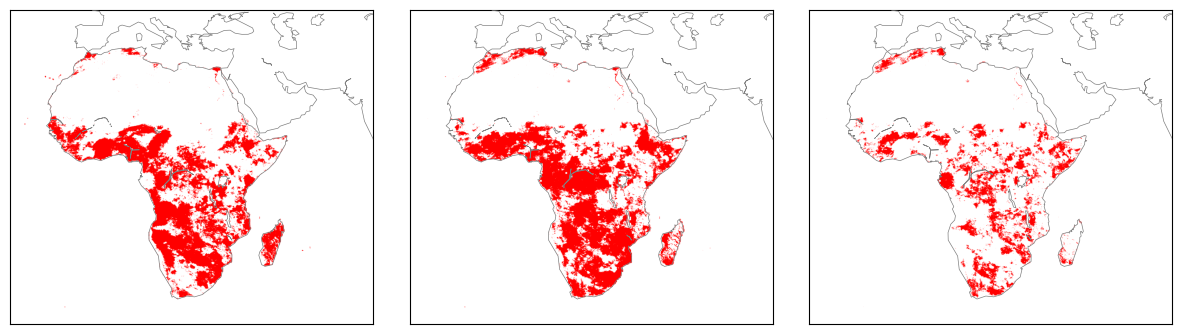

In [7]:
dt_dr=np.zeros((3,1800,2080))
dt_dr[0]=spei_ev[0]
dt_dr[1]=spei_ev[1]
dt_dr[2]=spei1516_only

from pylab import *
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
Lon=dt.variables['lon'][:]
Lat=dt.variables['lat'][:]
LonMin,LatMax,LonMax,LatMin = [Lon.min(),Lat.max(),Lon.max(),Lat.min()]
plt.rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
plt.rc('lines', linewidth = 1.5) 
#plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.3, hspace=0.2)
lon1 = LonMin;lon2 = LonMax
lat1 = LatMin;lat2 = LatMax
fig = plt.figure(figsize=(15,5)) ##width, height default(8,6)
plt.subplots_adjust(wspace=0.1,hspace=0.1)
for i in range(3):
    ax = fig.add_subplot(1,3,i+1)
    m = Basemap(llcrnrlon=lon1,llcrnrlat=lat1,urcrnrlon=lon2,urcrnrlat=lat2)
    #m.drawmapboundary(linewidth=1,fill_color = 'lightcyan')
    m.drawcoastlines(linewidth=0.5, color='gray',zorder=40)
    clist=['white','red']
    cmp=LinearSegmentedColormap.from_list('chaos',clist)
    im = m.imshow(dt_dr[i],cmap =cmp,origin='upper')

#2012-2014年干旱区域，2015-2016年干旱区域，仅2015-2016年干旱区域

# Monthly resistance data

In [ ]:
# 2015年：0,1,2,3,4,5,6,7,8,9,10,11,2016年：12,13,14,15,16,17,18,19,20,21,22,23

## SIF

In [69]:
doc_csif=['D:/CSIF/2012/','D:/CSIF/2013/','D:/CSIF/2014/','D:/CSIF/2015/','D:/CSIF/2016/']
#montly integrated of SIF data
#dn=[31,28,31,30,31,30,31,31,30,31,30,31]#day-numbers of each month
k=np.arange(1,366,4)
dy=[0,31,59,90,120,151,181,212,243,273,304,334,365]
#z_mean=np.zeros((92,3600,7200))
m_mean=np.zeros((5,12,3600,7200))
for i in range(5):
    print("yr:",i,'\n')
    for j in range(12):
        print(j,',')
        mon_tip=[]
        for m in range(92):
            dt=Dataset(doc_csif[i]+'OCO2.SIF.clear.inst.20{}{:0>3d}.v2.nc'.format(i+12,k[m]))
            cs_inst=dt.variables['clear_inst_SIF']
            #z_mean[m,:,:]=np.array(cs_inst)
            if k[m]>dy[j] and k[m]<=dy[j+1]:
                mon_tip.append(cs_inst)
        m_mean[i,j,:,:]=np.mean(mon_tip,axis=0)
m_mean.shape

yr: 0 

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,
yr: 1 

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,
yr: 2 

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,
yr: 3 

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,
yr: 4 

0 ,
1 ,
2 ,
3 ,
4 ,
5 ,
6 ,
7 ,
8 ,
9 ,
10 ,
11 ,


(5, 12, 3600, 7200)

## 导出 tif

In [72]:
mm_mean=np.zeros((5,12,3600,7200))
for i in range(5):
    for j in range(12):
        mm_mean[i,j,:,:]=np.flipud(m_mean[i,j,:,:])        

In [73]:
sif_out='//weili/User2/mxsun/CESS_230818/Resistance_monthly/SIF_monthly/'
#-25,38,52,-47
from osgeo import gdal,osr,ogr
pathin='D:/CSIF/'
ref=Dataset(doc_csif[0]+'OCO2.SIF.clear.inst.2012001.v2.nc')
lon=np.array(ref.variables['lon'])
lat=np.array(ref.variables['lat'])
lonmin,latmax,lonmax,latmin=[lon.min(),lat.max(),lon.max(),lat.min()]
#计算分辨率
n_lat=len(lat)
n_lon=len(lon)
lon_res=(lonmax-lonmin)/(float(n_lon)-1)
lat_res=(latmax-latmin)/(float(n_lat)-1)
#创建tif文件
driver=gdal.GetDriverByName('GTiff')

for i in range(5):
    for j in range(12):
        print(j,'/')
        out_tif_name=sif_out+'CSIF_monthly_20{}{:0>2d}.tif'.format(i+12,j+1)
        out_tif=driver.Create(out_tif_name,n_lon,n_lat,1,gdal.GDT_Float32)
        #设置影像的显示范围
        geotransform=(lonmin,lon_res,0,latmax,0,-lat_res)
        out_tif.SetGeoTransform(geotransform)
        #获取地理坐标系统信息，用于选取需要的地理坐标系统
        srs = osr.SpatialReference()
        srs.ImportFromEPSG(4326) # 定义输出的坐标系为"WGS 84"，AUTHORITY["EPSG","4326"]
        out_tif.SetProjection(srs.ExportToWkt()) # 给新建图层赋予投影信息
        #去除异常值    
        #pd_3yr[pd_3yr==32768] = -1
        #数据写出
        out_tif.GetRasterBand(1).WriteArray(mm_mean[i,j,:,:])
        out_tif.GetRasterBand(1).SetNoDataValue(-1)
        out_tif.FlushCache() # 将数据写入硬盘
        del out_tif # 注意必须关闭tif文件
        #return nc_data_obj.variables

0 /
1 /
2 /
3 /
4 /
5 /
6 /
7 /
8 /
9 /
10 /
11 /
0 /
1 /
2 /
3 /
4 /
5 /
6 /
7 /
8 /
9 /
10 /
11 /
0 /
1 /
2 /
3 /
4 /
5 /
6 /
7 /
8 /
9 /
10 /
11 /
0 /
1 /
2 /
3 /
4 /
5 /
6 /
7 /
8 /
9 /
10 /
11 /
0 /
1 /
2 /
3 /
4 /
5 /
6 /
7 /
8 /
9 /
10 /
11 /


## 提取非洲部分

In [74]:
#读取mask的坐标信息，然后warp drought数据
def GetExtent(infile):
    ds = gdal.Open(infile)
    geotrans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    min_x,max_y = geotrans[0],geotrans[3]
    max_x,min_y = geotrans[0]+xsize*geotrans[1],geotrans[3]+ysize*geotrans[5]
    ds = None
    return min_x,max_y,max_x,min_y
tt=GetExtent(spei_path+'csif_resistance_230321.tif')
tt

(-26.0, 25.0, 53.0, -40.0)

### sif

In [76]:
sif_afr='//weili/User2/mxsun/CESS_230818/Resistance_monthly/SIF_monthly/sif_afr/'
for i in range(5):
    for j in range(12):
        gdal.Warp(sif_afr+'CSIF_monthly_afr_20{}{:0>2d}.tif'.format(i+12,j+1),
                  sif_out+'CSIF_monthly_20{}{:0>2d}.tif'.format(i+12,j+1),
                  dstSRS='EPSG:4326',
                  outputBounds = [tt[0],tt[3],tt[2],tt[1]],
                  xRes=0.01,
                  yRes=0.01,
                  targetAlignedPixels=True,
                  resampleAlg = gdalconst.GRA_Average,
                  creationOptions = ["COMPRESS=LZW"])

### ndvi

In [78]:
ndvi_in='//weili/User2/mxsun/CESS_230818/Resistance_monthly/NDVI_monthly/'
ndvi_out='//weili/User2/mxsun/CESS_230818/Resistance_monthly/NDVI_monthly/ndvi_afr/'
for i in range(5):
    for j in range(12):
        gdal.Warp(ndvi_out+'NDVI_monthly_afr_20{}{:0>2d}.tif'.format(i+12,j+1),
                  ndvi_in+'NDVI20{}_{}.tif'.format(i+12,j+1),
                  dstSRS='EPSG:4326',
                  outputBounds = [tt[0],tt[3],tt[2],tt[1]],
                  xRes=0.01,
                  yRes=0.01,
                  targetAlignedPixels=True,
                  resampleAlg = gdalconst.GRA_Average,
                  creationOptions = ["COMPRESS=LZW"])

# Drought resistance

## drought mask

In [2]:
dr_month=read_img(spei_path+'drought_monthly_afr_record_240523_sub.tif')[0]
dr_month.shape

(24, 6500, 7900)

In [3]:
#根据monthly drought， 对应月份逐格点求drought resistance
#shape of dr_month is (24,1800,2080),2015-2016年逐月
dr_15=dr_month[:12,:,:]
dr_16=dr_month[12:,:,:]
print(dr_15.shape,dr_16.shape)
dr_16[dr_16==1]=2
dr_comb=dr_15+dr_16
dr_comb.shape

(12, 6500, 7900) (12, 6500, 7900)


(12, 6500, 7900)

In [4]:
np.unique(dr_comb)

array([0., 1., 2., 3.], dtype=float32)

In [5]:
#----------------------------
# monthly drought mask for 2012-2014
dr_mask1214=np.copy(dr_comb)
dr_mask1214[dr_mask1214>0]=1
#----------------------------
# monthly drought mask for 2015
dr_mask15=np.copy(dr_comb)
dr_mask15[dr_mask15>1]=0
# monthly drought mask for 2016
dr_mask16=np.copy(dr_comb)
dr_mask16[dr_mask16!=2]=0
dr_mask16[dr_mask16==2]=1
# monthly drought mask for 2015 and 2016
dr_mask1516=np.copy(dr_comb)
dr_mask1516[dr_mask1516!=3]=0
dr_mask1516[dr_mask1516==3]=1

## 计算resistance

### monthly vegetation(NDVI, SIF)

In [10]:
ndvi_path='//weili/User2/mxsun/CESS_230818/Resistance_monthly/NDVI_monthly/ndvi_afr/'
sif_path='//weili/User2/mxsun/CESS_230818/Resistance_monthly/SIF_monthly/sif_afr/'
#2012-2014年按月合并，逐月求均值
ndvi12_14_month=np.zeros((12,6500,7900))
sif12_14_month=np.zeros((12,6500,7900))
for i in range(12):
    ndvi12=read_img(ndvi_path+'NDVI_monthly_afr_2012{:0>2d}.tif'.format(i+1))[0]
    ndvi13=read_img(ndvi_path+'NDVI_monthly_afr_2013{:0>2d}.tif'.format(i+1))[0]
    ndvi14=read_img(ndvi_path+'NDVI_monthly_afr_2014{:0>2d}.tif'.format(i+1))[0]
    ndvi12_14_month[i]=(ndvi12+ndvi13+ndvi14)/3
    sif12=read_img(sif_path+'CSIF_monthly_afr_2012{:0>2d}.tif'.format(i+1))[0]
    sif13=read_img(sif_path+'CSIF_monthly_afr_2013{:0>2d}.tif'.format(i+1))[0]
    sif14=read_img(sif_path+'CSIF_monthly_afr_2014{:0>2d}.tif'.format(i+1))[0]
    sif12_14_month[i]=(sif12+sif13+sif14)/3

#2015-2016年按月合并，逐月求均值
ndvi1516_month=np.zeros((12,6500,7900))
sif1516_month=np.zeros((12,6500,7900))
for i in range(12):
    ndvi15=read_img(ndvi_path+'NDVI_monthly_afr_2015{:0>2d}.tif'.format(i+1))[0]
    ndvi16=read_img(ndvi_path+'NDVI_monthly_afr_2016{:0>2d}.tif'.format(i+1))[0]
    ndvi1516_month[i]=(ndvi15+ndvi16)/2
    sif15=read_img(sif_path+'CSIF_monthly_afr_2015{:0>2d}.tif'.format(i+1))[0]
    sif16=read_img(sif_path+'CSIF_monthly_afr_2016{:0>2d}.tif'.format(i+1))[0]
    sif1516_month[i]=(sif15+sif16)/2

In [11]:
ndvi15_month=np.zeros((12,6500,7900))
sif15_month=np.zeros((12,6500,7900))
ndvi16_month=np.zeros((12,6500,7900))
sif16_month=np.zeros((12,6500,7900))
for i in range(12):
    ndvi15_month[i]=read_img(ndvi_path+'NDVI_monthly_afr_2015{:0>2d}.tif'.format(i+1))[0]
    ndvi16_month[i]=read_img(ndvi_path+'NDVI_monthly_afr_2016{:0>2d}.tif'.format(i+1))[0]
    sif15_month[i]=read_img(sif_path+'CSIF_monthly_afr_2015{:0>2d}.tif'.format(i+1))[0]
    sif16_month[i]=read_img(sif_path+'CSIF_monthly_afr_2016{:0>2d}.tif'.format(i+1))[0]

### monthly drought resistance

In [74]:
#ndvi and sif monthly in 2012-2014
pre_ndvi=np.zeros((12,6500,7900))
pre_sif=np.zeros((12,6500,7900))
for i in range(12):
    pre_ndvi[i]=ndvi12_14_month[i]*dr_mask1214[i]
    pre_sif[i]=sif12_14_month[i]*dr_mask1214[i]
pre_ndvi[pre_ndvi<=0]=np.nan
pre_ndvi=np.nanmean(pre_ndvi,axis=0)
pre_sif[pre_sif<=0]=np.nan
pre_sif=np.nanmean(pre_sif,axis=0)

C:\Users\dess\AppData\Local\Temp\ipykernel_26632\663622836.py:8: RuntimeWarning: Mean of empty slice
  pre_ndvi=np.nanmean(pre_ndvi,axis=0)
C:\Users\dess\AppData\Local\Temp\ipykernel_26632\663622836.py:10: RuntimeWarning: Mean of empty slice
  pre_sif=np.nanmean(pre_sif,axis=0)


In [154]:
#ndvi and sif monthly in 2015,2016 and 2015-2016
ndvi15=np.zeros((12,6500,7900))
sif15=np.zeros((12,6500,7900))
ndvi16=np.zeros((12,6500,7900))
sif16=np.zeros((12,6500,7900))
ndvi1516=np.zeros((12,6500,7900))
sif1516=np.zeros((12,6500,7900))

for i in range(12):
    ndvi15[i]=ndvi15_month[i]*dr_mask15[i]
    sif15[i]=sif15_month[i]*dr_mask15[i]
    ndvi16[i]=ndvi16_month[i]*dr_mask16[i]
    sif16[i]=sif16_month[i]*dr_mask16[i]
    ndvi1516[i]=ndvi1516_month[i]*dr_mask1516[i]
    sif1516[i]=sif1516_month[i]*dr_mask1516[i]

def res(veg,pre):
    veg[veg<=0]=np.nan
    veg=np.nanmean(veg,axis=0)
    pre[pre==0]=np.nan
    res=veg/pre
    res[np.isnan(res)]=0
    return res

res_ndvi15=res(ndvi15,pre_ndvi)
res_ndvi16=res(ndvi16,pre_ndvi)
res_ndvi1516=res(ndvi1516,pre_ndvi)
res_sif15=res(sif15,pre_sif)
res_sif16=res(sif16,pre_sif)
res_sif1516=res(sif1516,pre_sif)

C:\Users\dess\AppData\Local\Temp\ipykernel_26632\4054080801.py:19: RuntimeWarning: Mean of empty slice
  veg=np.nanmean(veg,axis=0)


In [170]:
dt=read_img(spei_path+'csif_resistance_230321.tif')
write_img(spei_path+'ndvi_resistance_2015_240525.tif',dt[4],dt[3],res_ndvi15)
write_img(spei_path+'ndvi_resistance_2016_240525.tif',dt[4],dt[3],res_ndvi16)
write_img(spei_path+'ndvi_resistance_1516_240525.tif',dt[4],dt[3],res_ndvi1516)

write_img(spei_path+'sif_resistance_2015_240525.tif',dt[4],dt[3],res_sif15)
write_img(spei_path+'sif_resistance_2016_240525.tif',dt[4],dt[3],res_sif16)
write_img(spei_path+'sif_resistance_1516_240525.tif',dt[4],dt[3],res_sif1516)

## monthly drought resistance，补充growth season mask

In [6]:
#calculation of growth seasons look at "py_v5_03_VIPPHEN_EVI2 v004_240607"
season_path='//weili/User2/mxsun/CESS_230818/Resistance_monthly/growth_season/'
gs_start=read_img(season_path+'VIPPHEN_EVI2_start-month_240607_sub.tif')[0]
gs_end=read_img(season_path+'VIPPHEN_EVI2_end-month_240607_sub.tif')[0]
np.min(gs_start),np.max(gs_start)

(0.0, 12.0)

In [187]:
gs_start.dtype

dtype('float32')

### mask growth season

In [9]:
#dr_mask 加上growth season mask
    #将生长期外的1全改为0
#注意：北半球gs_start<gs_end,南半球gs_start>gs_end
def growth_season_mask(dr_mask,gs_start,gs_end):
    mask_to_keep=np.zeros((12,6500,7900))#ndarray of False as shape in (6500,7900).
    for i in range(6500):
        for j in range(7900):
            start, end = int(gs_start[i,j]-1), int(gs_end[i,j]-1)# 数组索引从0开始，所以月份要减1
            if start<end:#北半球
                mask_to_keep[start:end+1,i,j]=1#假如gs_start值等于4，gs_end=10时，将dr_mask[:3,6500,7900]和dr_mask[11:,6500,7900]全改为0
            else:#南半球
                mask_to_keep[:end+1,i,j]=1
                mask_to_keep[start:,i,j]=1
    dr_mask=dr_mask * mask_to_keep
    return dr_mask
dr_mask1214=growth_season_mask(dr_mask1214,gs_start,gs_end)
dr_mask15=growth_season_mask(dr_mask15,gs_start,gs_end)
dr_mask16=growth_season_mask(dr_mask16,gs_start,gs_end)
dr_mask1516=growth_season_mask(dr_mask1516,gs_start,gs_end)

### 计算drought resistance

In [12]:
#ndvi and sif monthly in 2012-2014
pre_ndvi=np.zeros((12,6500,7900))
pre_sif=np.zeros((12,6500,7900))
for i in range(12):
    pre_ndvi[i]=ndvi12_14_month[i]*dr_mask1214[i]
    pre_sif[i]=sif12_14_month[i]*dr_mask1214[i]
pre_ndvi[pre_ndvi<=0]=np.nan
pre_ndvi=np.nanmean(pre_ndvi,axis=0)
pre_sif[pre_sif<=0]=np.nan
pre_sif=np.nanmean(pre_sif,axis=0)

C:\Users\dess\AppData\Local\Temp\ipykernel_29912\663622836.py:8: RuntimeWarning: Mean of empty slice
  pre_ndvi=np.nanmean(pre_ndvi,axis=0)
C:\Users\dess\AppData\Local\Temp\ipykernel_29912\663622836.py:10: RuntimeWarning: Mean of empty slice
  pre_sif=np.nanmean(pre_sif,axis=0)


In [13]:
#ndvi and sif monthly in 2015,2016 and 2015-2016
ndvi15=np.zeros((12,6500,7900))
sif15=np.zeros((12,6500,7900))
ndvi16=np.zeros((12,6500,7900))
sif16=np.zeros((12,6500,7900))
ndvi1516=np.zeros((12,6500,7900))
sif1516=np.zeros((12,6500,7900))

for i in range(12):
    ndvi15[i]=ndvi15_month[i]*dr_mask15[i]
    sif15[i]=sif15_month[i]*dr_mask15[i]
    ndvi16[i]=ndvi16_month[i]*dr_mask16[i]
    sif16[i]=sif16_month[i]*dr_mask16[i]
    ndvi1516[i]=ndvi1516_month[i]*dr_mask1516[i]
    sif1516[i]=sif1516_month[i]*dr_mask1516[i]

def res(veg,pre):
    veg[veg<=0]=np.nan
    veg=np.nanmean(veg,axis=0)
    pre[pre==0]=np.nan
    res=veg/pre
    res[np.isnan(res)]=0
    return res

res_ndvi15=res(ndvi15,pre_ndvi)
res_ndvi16=res(ndvi16,pre_ndvi)
res_ndvi1516=res(ndvi1516,pre_ndvi)
res_sif15=res(sif15,pre_sif)
res_sif16=res(sif16,pre_sif)
res_sif1516=res(sif1516,pre_sif)

C:\Users\dess\AppData\Local\Temp\ipykernel_29912\2350055163.py:19: RuntimeWarning: Mean of empty slice
  veg=np.nanmean(veg,axis=0)


In [14]:
dt=read_img(spei_path+'csif_resistance_230321.tif')
write_img(spei_path+'ndvi_resistance_gs_2015_240525.tif',dt[4],dt[3],res_ndvi15)
write_img(spei_path+'ndvi_resistance_gs_2016_240525.tif',dt[4],dt[3],res_ndvi16)
write_img(spei_path+'ndvi_resistance_gs_1516_240525.tif',dt[4],dt[3],res_ndvi1516)

write_img(spei_path+'sif_resistance_gs_2015_240525.tif',dt[4],dt[3],res_sif15)
write_img(spei_path+'sif_resistance_gs_2016_240525.tif',dt[4],dt[3],res_sif16)
write_img(spei_path+'sif_resistance_gs_1516_240525.tif',dt[4],dt[3],res_sif1516)